# RealHiTBench Qwen3-VL 结果可视化
此notebook用于可视化RealHiTBench项目的Qwen3-VL模型结果，支持多模态数据的分析和图表生成

In [63]:
import json, sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

PROJECT_ROOT = Path('/export/home/pan/4xin/RealHiTBENCH-Qwen3-VL')

# 字体设置（无需sudo权限的解决方案）
available_fonts = [f.name for f in fm.fontManager.ttflist]
font_priority = ['Times New Roman', 'Liberation Serif', 'DejaVu Serif', 'Noto Serif', 'Times']
selected_font = next((f for f in font_priority if f in available_fonts), 'serif')

plt.rcParams['font.family'] = selected_font if selected_font != 'serif' else 'serif'
plt.rcParams['font.serif'] = font_priority
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

TASK_METRICS = {
    'Fact Checking': ['F1', 'EM'],
    'Numerical Reasoning': ['F1', 'EM'],
    'Structure Comprehending': ['F1', 'EM'],
    'Data Analysis': ['ROUGE-L', 'F1', 'EM'],
    'Visualization': ['ECR', 'Pass']
}

print(f"✓ 项目路径: {PROJECT_ROOT}")
print(f"✓ 选用字体: {selected_font}")

✓ 项目路径: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL
✓ 选用字体: Liberation Serif


In [64]:
# 定义核心函数：计算指标
def calc_metrics(df):
    task_scores = {}
    all_scores = []
    
    for task, metrics in TASK_METRICS.items():
        task_data = df[df['QuestionType'] == task]
        if len(task_data) == 0:
            continue
        
        scores = []
        for metric in metrics:
            col = f'Metrics.{metric}'
            if col in task_data.columns:
                if metric in ['F1', 'EM', 'ROUGE-L']:
                    avg = task_data[col].mean()
                else:
                    avg = ((task_data[col] == True).sum() / len(task_data)) * 100
                scores.append(avg)
                all_scores.append(avg)
        
        if scores:
            task_scores[task] = np.mean(scores)
    
    return task_scores, np.mean(all_scores) if all_scores else 0

print("✓ calc_metrics 函数已定义")

✓ calc_metrics 函数已定义


In [65]:
# 定义绘图函数
def draw_single_modality_chart(modality, metrics, output_dir):
    """绘制单个模态的任务对比图"""
    output_dir.mkdir(parents=True, exist_ok=True)
    
    task_keys = list(TASK_METRICS.keys())
    tasks = ['Fact Checking', 'Numerical', 'Structure', 'Data Analysis', 'Visualization', 'Overall']
    scores = [metrics['tasks'].get(k, 0) for k in task_keys] + [metrics['overall']]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x = np.arange(len(tasks))
    bars = ax.bar(x, scores, color=['#4C78A8', '#9EC8E8', '#6CB4E3', '#54B6EB', '#72C8F5', '#A0D5FF'],
                  edgecolor='black', linewidth=1.5)
    
    for bar, score in zip(bars, scores):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{score:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Average Score', fontsize=14, fontweight='bold')
    ax.set_title(f'{modality.upper()} - Task Comparison', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, fontsize=12)
    ax.set_ylim(0, max(scores) * 1.2 if scores else 100)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(output_dir / f'{modality}_task_comparison.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"  ✓ {modality}_task_comparison.png")

def draw_task_comparison_with_overall(model_name, model_metrics, output_dir):
    """绘制跨模态对比图（含Overall列）"""
    task_keys = list(TASK_METRICS.keys())
    tasks = ['Fact\nChecking', 'Numerical\nReasoning', 'Structure\nComprehending',
             'Data\nAnalysis', 'Chart\nGeneration', 'Overall']
    format_names = list(model_metrics.keys())
    if not format_names:
        print(f"  ⚠️  {model_name}: 无可用模态")
        return
    
    label_map = {
        'text_latex': 'Text_Latex', 'text_html': 'Text_Html', 'text_markdown': 'Text_Markdown',
        'text_json': 'Text_JSON', 'text_csv': 'Text_CSV',
        'mix_latex': 'Mix_Latex', 'mix_html': 'Mix_Html', 'mix_markdown': 'Mix_Markdown',
        'mix_json': 'Mix_JSON', 'mix_csv': 'Mix_CSV'
    }
    format_labels = [label_map.get(fmt, fmt) for fmt in format_names]
    # 颜色对应: Latex(红) / Html(黄) / Markdown(蓝) / JSON(绿) / CSV(紫)
    colors = ['#C44E52', '#FFA500', '#5975A4', '#66A266', '#7A4EAB']
    text_colors = ['#8B0000', '#CC8800', '#4169E1', '#228B22', '#5E3A9A']
    width = 0.14 if len(format_names) > 4 else 0.18
    x = np.arange(len(tasks))
    fig, ax = plt.subplots(figsize=(16, 8))
    
    all_scores = []
    for fmt in format_names:
        scores = [model_metrics[fmt]['tasks'].get(task, 0) for task in task_keys] + [model_metrics[fmt]['overall']]
        all_scores.extend(scores)
    max_score = max(all_scores) if all_scores else 0
    y_max = int(np.ceil((max_score * 1.15) / 10) * 10) if max_score > 0 else 100
    
    offset_center = (len(format_names) - 1) / 2.0
    for i, (fmt, label) in enumerate(zip(format_names, format_labels)):
        scores = [model_metrics[fmt]['tasks'].get(task, 0) for task in task_keys] + [model_metrics[fmt]['overall']]
        offset = width * (i - offset_center)
        bars = ax.bar(x + offset, scores, width, label=label, color=colors[i % len(colors)],
                      edgecolor='black', linewidth=0.5)
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{score:.2f}',
                    ha='center', va='bottom', fontsize=11, color=text_colors[i % len(text_colors)],
                    fontweight='bold')
    
    ax.set_xlabel('', fontsize=16, fontweight='bold')
    ax.set_ylabel('Task Average Score', fontsize=18, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, fontsize=16, fontweight='normal')
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.arange(0, y_max + 1, 10))
    ax.legend(fontsize=16, loc='upper right', frameon=True, edgecolor='black', fancybox=False, shadow=False)
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    plt.tight_layout()
    plt.show()
    fig.savefig(output_dir / 'task_comparison_with_overall.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig)
    print("  ✓ task_comparison_with_overall.png")

print("✓ 绘图函数已定义")

✓ 绘图函数已定义


In [66]:
def generate_visualization(model_dir, modalities, model_name="model"):
    """
    生成指定模型的所有可视化图表
    
    参数:
        model_dir: Path对象，模型结果目录路径
        modalities: list，模态名称列表（如 ['text_latex', 'text_html', ...]）
        model_name: str，模型名称（用于打印和标题）
    
    返回:
        tuple: (model_metrics, modality_data) - 指标字典和原始数据字典
    """
    print(f"\n{'='*60}")
    print(f"开始处理: {model_name}")
    print(f"模型目录: {model_dir}")
    print(f"模态列表: {', '.join(modalities)}")
    print(f"{'='*60}\n")
    
    # 1. 加载数据
    modality_data = {}
    print(f"[1/4] 加载模态数据...")
    for modality in modalities:
        results_file = model_dir / modality / 'results.json'
        if not results_file.exists():
            print(f"  ⚠️  {modality}: 文件不存在，跳过")
            continue
        
        with open(results_file) as f:
            data = json.load(f)
        
        df = pd.json_normalize(data.get('results', []))
        modality_data[modality] = df
        print(f"  ✓ {modality}: {len(df)} 样本")
    
    if not modality_data:
        print(f"❌ 无可用数据，终止处理")
        return None, None
    
    print(f"成功加载 {len(modality_data)} 个模态\n")
    
    # 2. 计算指标
    print(f"[2/4] 计算性能指标...")
    model_metrics = {}
    for modality, df in modality_data.items():
        tasks, overall = calc_metrics(df)
        model_metrics[modality] = {'tasks': tasks, 'overall': overall}
        print(f"  {modality}: Overall={overall:.2f}")
    print()
    
    # 3. 生成单模态图表
    print(f"[3/4] 生成单模态图表...")
    for modality, metrics in model_metrics.items():
        output_dir = model_dir / modality
        draw_single_modality_chart(modality, metrics, output_dir)
    print()
    
    # 4. 生成跨模态对比图
    print(f"[4/4] 生成跨模态对比图...")
    draw_task_comparison_with_overall(model_name, model_metrics, model_dir)
    print()
    
    # 5. 汇总统计
    print(f"汇总统计:")
    task_keys = list(TASK_METRICS.keys())
    summary_data = {}
    for modality in modality_data.keys():
        metrics = model_metrics.get(modality, {'tasks': {}, 'overall': 0})
        summary_data[modality] = [metrics['tasks'].get(t, 0) for t in task_keys] + [metrics['overall']]
    
    summary_df = pd.DataFrame(summary_data, index=task_keys + ['Overall']).T
    print(summary_df.to_string())
    
    csv_path = model_dir / 'modality_summary.csv'
    summary_df.to_csv(csv_path)
    print(f"\n✓ 汇总表已保存: {csv_path}")
    
    print(f"\n最佳模态:")
    for col in summary_df.columns:
        best = summary_df[col].idxmax()
        score = summary_df[col].max()
        print(f"  {col:<30} -> {best:<20} ({score:6.2f})")
    
    print(f"\n{'='*60}")
    print(f"✅ {model_name} 处理完成！")
    print(f"{'='*60}\n")
    
    return model_metrics, modality_data


def draw_three_modality_comparison(text_data_dict, image_df, mix_data_dict, output_dir):
    """
    绘制三模态对比图：Text_Average, Image, Mix_Average
    
    参数:
        text_data_dict: dict, text模态的DataFrame字典 {modality_name: df}
        image_df: DataFrame, image模态的原始数据
        mix_data_dict: dict, mix模态的DataFrame字典 {modality_name: df}
        output_dir: Path, 输出目录
    """
    task_keys = list(TASK_METRICS.keys())
    tasks = ['Fact\nChecking', 'Numerical\nReasoning', 'Structure\nComprehending',
             'Data\nAnalysis', 'Chart\nGeneration']
    
    # 计算 text_average（合并所有text模态的原始数据后计算平均）
    text_avg_scores = {}
    all_text_dfs = list(text_data_dict.values())
    if all_text_dfs:
        text_combined_df = pd.concat(all_text_dfs, ignore_index=True)
        text_tasks, _ = calc_metrics(text_combined_df)
        text_avg_scores = text_tasks
    
    # 计算 mix_average（合并所有mix模态的原始数据后计算平均）
    mix_avg_scores = {}
    all_mix_dfs = list(mix_data_dict.values())
    if all_mix_dfs:
        mix_combined_df = pd.concat(all_mix_dfs, ignore_index=True)
        mix_tasks, _ = calc_metrics(mix_combined_df)
        mix_avg_scores = mix_tasks
    
    # 计算 image 的任务得分
    image_tasks, _ = calc_metrics(image_df)
    image_task_scores = image_tasks
    
    # 准备绘图数据
    text_scores = [text_avg_scores.get(task, 0) for task in task_keys]
    image_scores = [image_task_scores.get(task, 0) for task in task_keys]
    mix_scores = [mix_avg_scores.get(task, 0) for task in task_keys]
    
    # 创建图表
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(tasks))
    width = 0.25
    
    # 三组柱状图 - 高级配色：Text(深邃蓝) / Image(活力橙) / Mix(高贵紫，体现融合)
    bars1 = ax.bar(x - width, text_scores, width, label='Text_Average', 
                   color='#F9E7A7', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, image_scores, width, label='Image',
                   color='#EF767B', edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, mix_scores, width, label='Mix_Average',
                   color='#43A3EF', edgecolor='black', linewidth=0.5)
    
    # 添加数值标签
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    # 设置坐标轴
    ax.set_xlabel('', fontsize=16, fontweight='bold')
    ax.set_ylabel('Task Average Score', fontsize=18, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, fontsize=16, fontweight='normal')
    
    # 动态设置y轴范围
    all_scores = text_scores + image_scores + mix_scores
    max_score = max(all_scores) if all_scores else 0
    y_max = int(np.ceil((max_score * 1.15) / 10) * 10) if max_score > 0 else 100
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.arange(0, y_max + 1, 10))
    
    # 图例和网格
    ax.legend(fontsize=16, loc='upper right', frameon=True, edgecolor='black', 
              fancybox=False, shadow=False)
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # 设置背景和边框
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    output_path = output_dir / 'three_modality_comparison.png'
    fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close(fig)
    
    print(f"\n✓ 三模态对比图已保存: {output_path}")
    
    # 打印统计信息
    print(f"\n三模态任务得分对比:")
    print(f"{'Task':<30} {'Text_Avg':<12} {'Image':<12} {'Mix_Avg':<12}")
    print("-" * 66)
    for i, task in enumerate(task_keys):
        print(f"{task:<30} {text_scores[i]:>10.2f}  {image_scores[i]:>10.2f}  {mix_scores[i]:>10.2f}")

print("✓ 主函数和三模态对比函数已定义")

✓ 主函数和三模态对比函数已定义



开始处理: qwen3vl_text
模型目录: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL/result/complied/qwen3vl_text
模态列表: text_latex, text_html, text_markdown, text_json, text_csv

[1/4] 加载模态数据...
  ✓ text_latex: 3067 样本
  ✓ text_html: 3063 样本
  ✓ text_markdown: 3068 样本
  ✓ text_json: 3063 样本
  ✓ text_csv: 3053 样本
成功加载 5 个模态

[2/4] 计算性能指标...
  text_latex: Overall=32.34
  text_html: Overall=31.04
  text_markdown: Overall=30.74
  text_json: Overall=34.08
  text_csv: Overall=28.84

[3/4] 生成单模态图表...
  ✓ text_latex_task_comparison.png
  ✓ text_html_task_comparison.png
  ✓ text_markdown_task_comparison.png
  ✓ text_json_task_comparison.png
  ✓ text_csv_task_comparison.png

[4/4] 生成跨模态对比图...


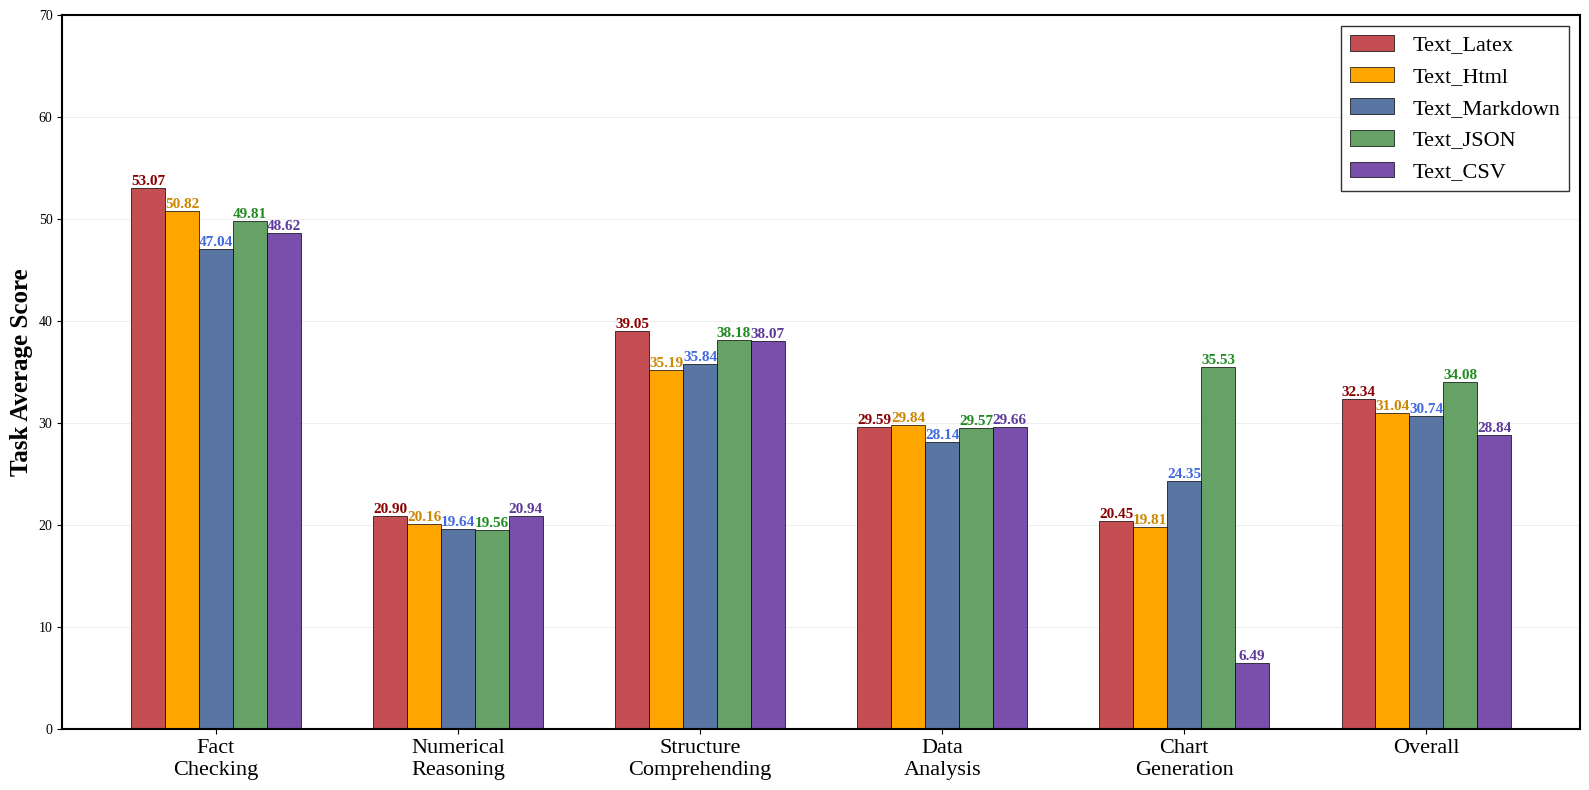

  ✓ task_comparison_with_overall.png

汇总统计:
               Fact Checking  Numerical Reasoning  Structure Comprehending  Data Analysis  Visualization    Overall
text_latex         53.074010            20.900110                39.048559      29.592826      20.454545  32.339357
text_html          50.821763            20.163923                35.191081      29.841192      19.805195  31.044318
text_markdown      47.041282            19.640272                35.837850      28.139781      24.350649  30.741768
text_json          49.805855            19.560996                38.179033      29.565121      35.526316  34.076342
text_csv           48.616511            20.939778                38.069324      29.660338       6.493506  28.838114

✓ 汇总表已保存: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL/result/complied/qwen3vl_text/modality_summary.csv

最佳模态:
  Fact Checking                  -> text_latex           ( 53.07)
  Numerical Reasoning            -> text_csv             ( 20.94)
  Structure Comp

In [67]:
# 调用函数 - Text模态（5种文本格式）
TEXT_MODEL_DIR = PROJECT_ROOT / 'result' / 'complied' / 'qwen3vl_text'
TEXT_MODALITIES = ['text_latex', 'text_html', 'text_markdown', 'text_json', 'text_csv']

text_metrics, text_data = generate_visualization(
    model_dir=TEXT_MODEL_DIR,
    modalities=TEXT_MODALITIES,
    model_name="qwen3vl_text"
)


开始处理: qwen3vl_default_pic
模型目录: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL/result/complied/qwen3vl_default_pic
模态列表: mix_latex, mix_html, mix_markdown, mix_json, mix_csv

[1/4] 加载模态数据...
  ✓ mix_latex: 3068 样本
  ✓ mix_html: 3063 样本
  ✓ mix_markdown: 3068 样本
  ✓ mix_json: 3063 样本
  ✓ mix_csv: 3068 样本
成功加载 5 个模态

[2/4] 计算性能指标...
  mix_latex: Overall=41.37
  mix_html: Overall=39.31
  mix_markdown: Overall=39.34
  mix_json: Overall=39.47
  mix_csv: Overall=41.00

[3/4] 生成单模态图表...
  ✓ mix_latex_task_comparison.png
  ✓ mix_html_task_comparison.png
  ✓ mix_markdown_task_comparison.png
  ✓ mix_json_task_comparison.png
  ✓ mix_csv_task_comparison.png

[4/4] 生成跨模态对比图...


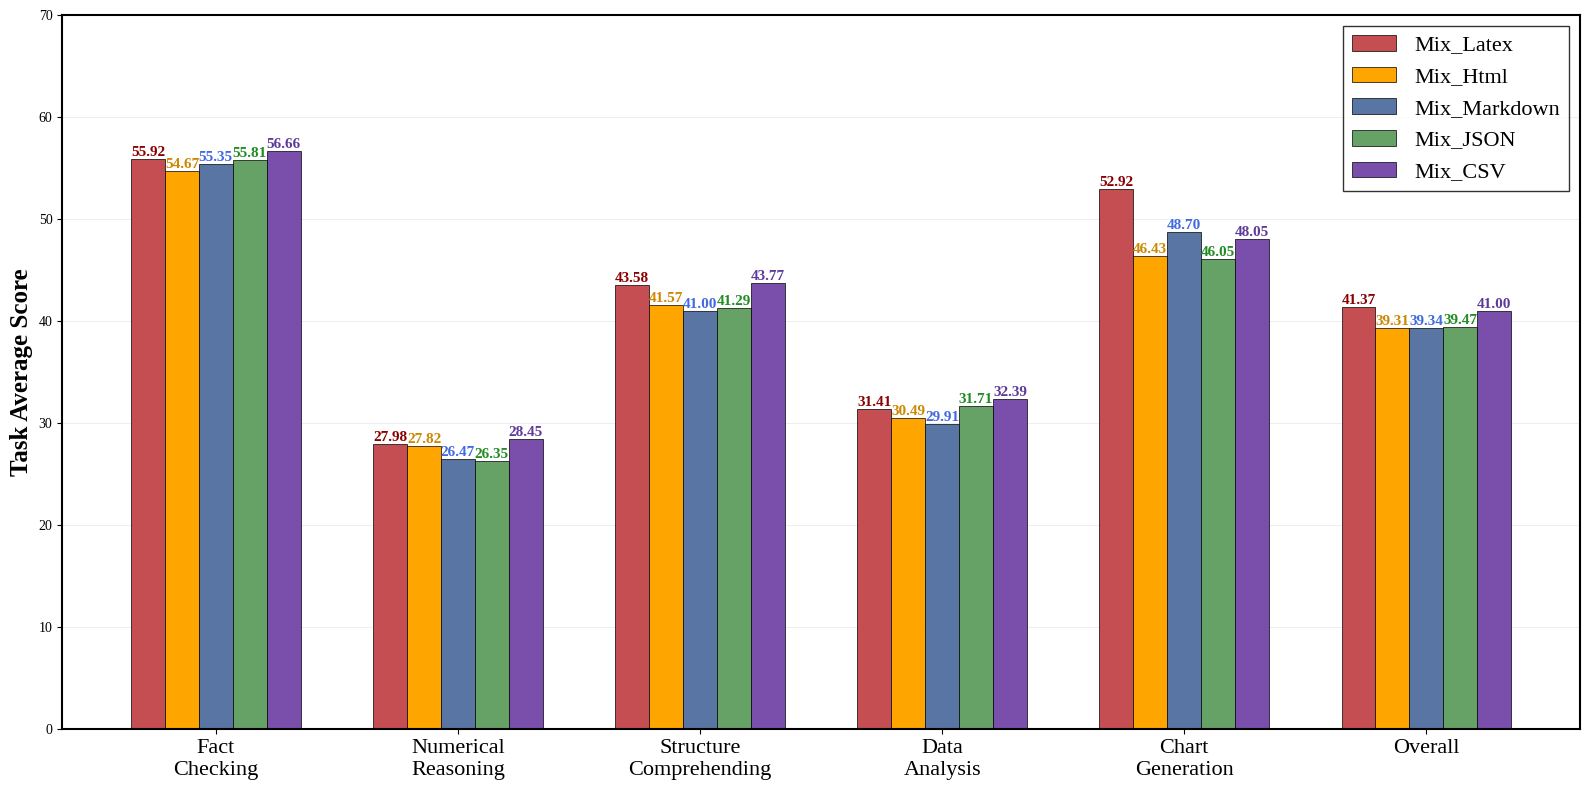

  ✓ task_comparison_with_overall.png

汇总统计:
              Fact Checking  Numerical Reasoning  Structure Comprehending  Data Analysis  Visualization    Overall
mix_latex         55.917921            27.979001                43.576514      31.408074      52.922078  41.365023
mix_html          54.669860            27.815830                41.570573      30.487546      46.428571  39.312028
mix_markdown      55.353221            26.470409                40.998333      29.906817      48.701299  39.342452
mix_json          55.813858            26.346217                41.285763      31.709723      46.052632  39.466010
mix_csv           56.656828            28.446887                43.768550      32.385963      48.051948  41.000574

✓ 汇总表已保存: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL/result/complied/qwen3vl_default_pic/modality_summary.csv

最佳模态:
  Fact Checking                  -> mix_csv              ( 56.66)
  Numerical Reasoning            -> mix_csv              ( 28.45)
  Structure Com

In [68]:
# 调用函数 - Mix模态（5种混合格式）
MIX_MODEL_DIR = PROJECT_ROOT / 'result' / 'complied' / 'qwen3vl_default_pic'
MIX_MODALITIES = ['mix_latex', 'mix_html', 'mix_markdown', 'mix_json', 'mix_csv']

mix_metrics, mix_data = generate_visualization(
    model_dir=MIX_MODEL_DIR,
    modalities=MIX_MODALITIES,
    model_name="qwen3vl_default_pic"
)


加载 Image 模态数据...

✓ Image 模态: 3070 样本


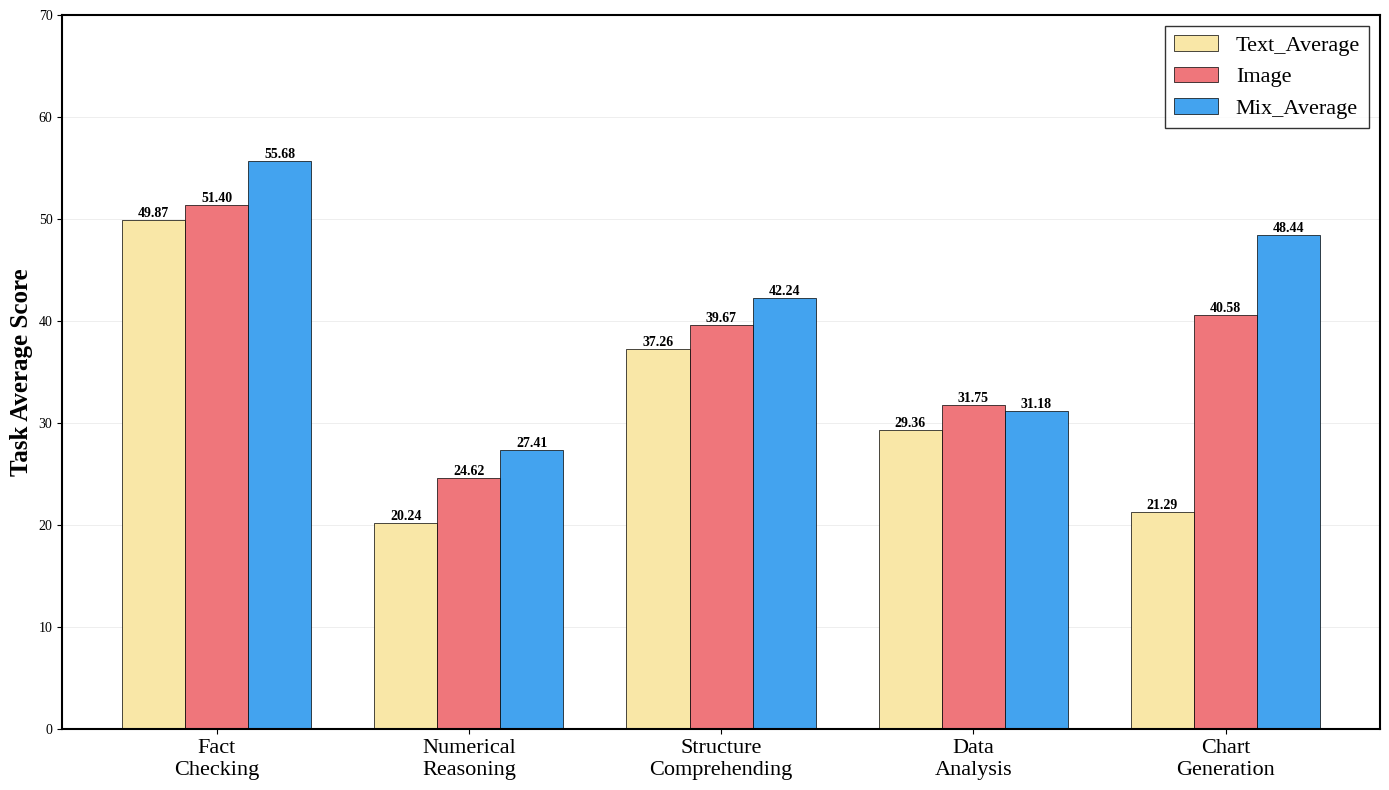


✓ 三模态对比图已保存: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL/result/complied/three_modality_comparison.png

三模态任务得分对比:
Task                           Text_Avg     Image        Mix_Avg     
------------------------------------------------------------------
Fact Checking                       49.87       51.40       55.68
Numerical Reasoning                 20.24       24.62       27.41
Structure Comprehending             37.26       39.67       42.24
Data Analysis                       29.36       31.75       31.18
Visualization                       21.29       40.58       48.44


In [69]:
# 加载 Image 模态数据并绘制三模态对比图
IMAGE_MODEL_DIR = PROJECT_ROOT / 'result' / 'complied' / 'qwen3vl_default_pic'
IMAGE_RESULTS_FILE = IMAGE_MODEL_DIR / 'image' / 'results.json'

print("\n" + "="*60)
print("加载 Image 模态数据...")
print("="*60 + "\n")

if IMAGE_RESULTS_FILE.exists():
    with open(IMAGE_RESULTS_FILE) as f:
        image_data = json.load(f)
    
    image_df = pd.json_normalize(image_data.get('results', []))
    print(f"✓ Image 模态: {len(image_df)} 样本")
    
    # 绘制三模态对比图
    if text_data and mix_data:
        draw_three_modality_comparison(
            text_data_dict=text_data,
            image_df=image_df,
            mix_data_dict=mix_data,
            output_dir=PROJECT_ROOT / 'result' / 'complied'
        )
    else:
        print("⚠️  text_data 或 mix_data 不可用，无法绘制三模态对比图")
else:
    print(f"❌ Image 数据文件不存在: {IMAGE_RESULTS_FILE}")

In [70]:
# 生成LaTeX格式表格
def generate_latex_table(text_data, image_data, mix_data, output_dir):
    """生成LaTeX格式的结果表格"""
    
    # 计算所有模态的指标
    all_results = {}
    
    # Text模态
    for modality_name, df in text_data.items():
        task_scores, overall = calc_metrics(df)
        all_results[modality_name] = {'tasks': task_scores, 'overall': overall, 'df': df}
    
    # Image模态
    image_tasks, image_overall = calc_metrics(image_data)
    all_results['image'] = {'tasks': image_tasks, 'overall': image_overall, 'df': image_data}
    
    # Mix模态
    for modality_name, df in mix_data.items():
        task_scores, overall = calc_metrics(df)
        all_results[modality_name] = {'tasks': task_scores, 'overall': overall, 'df': df}
    
    # 计算每个任务的详细指标
    def get_task_metrics(df, task):
        task_data = df[df['QuestionType'] == task]
        if len(task_data) == 0:
            return {}
        
        metrics = {}
        for metric in TASK_METRICS[task]:
            col = f'Metrics.{metric}'
            if col in task_data.columns:
                if metric in ['F1', 'EM', 'ROUGE-L']:
                    metrics[metric] = task_data[col].mean()
                else:  # ECR, Pass
                    metrics[metric] = ((task_data[col] == True).sum() / len(task_data)) * 100
        return metrics
    
    # 生成LaTeX代码
    latex_code = []
    latex_code.append("\\begin{table*}[t]")
    latex_code.append("\\centering")
    latex_code.append("\\caption{Performance of Qwen3-VL on RealHiTBench across different input modalities}")
    latex_code.append("\\label{tab:qwen3vl_results}")
    latex_code.append("\\resizebox{\\textwidth}{!}{")
    
    # 表格头部
    header = "\\begin{tabular}{ll"
    for task in TASK_METRICS.keys():
        header += "c" * len(TASK_METRICS[task])
    header += "}"
    latex_code.append(header)
    latex_code.append("\\toprule")
    
    # 第一行：任务名称
    task_header = "\\textbf{Model} & \\textbf{Input} & "
    task_cols = []
    for task in TASK_METRICS.keys():
        task_name = task.replace(' ', ' ')
        num_metrics = len(TASK_METRICS[task])
        task_cols.append(f"\\multicolumn{{{num_metrics}}}{{c}}{{\\textbf{{{task_name}}}}}")
    task_header += " & ".join(task_cols) + " \\\\"
    latex_code.append(task_header)
    
    # 第二行：指标名称
    metric_header = " & & "
    metric_cols = []
    for task in TASK_METRICS.keys():
        for metric in TASK_METRICS[task]:
            metric_cols.append(f"\\textbf{{{metric}}}")
    metric_header += " & ".join(metric_cols) + " \\\\"
    latex_code.append(metric_header)
    latex_code.append("\\midrule")
    
    # 模态标签映射
    modality_labels = {
        'text_latex': 'Text (LaTeX)',
        'text_html': 'Text (HTML)',
        'text_markdown': 'Text (Markdown)',
        'text_json': 'Text (JSON)',
        'text_csv': 'Text (CSV)',
        'image': 'Image',
        'mix_latex': 'Mix (LaTeX)',
        'mix_html': 'Mix (HTML)',
        'mix_markdown': 'Mix (Markdown)',
        'mix_json': 'Mix (JSON)',
        'mix_csv': 'Mix (CSV)'
    }
    
    # 模态顺序
    modality_order = [
        'text_latex', 'text_html', 'text_markdown', 'text_json', 'text_csv',
        'image',
        'mix_latex', 'mix_html', 'mix_markdown', 'mix_json', 'mix_csv'
    ]
    
    # 数据行
    for i, modality in enumerate(modality_order):
        if modality not in all_results:
            continue
        
        result = all_results[modality]
        df = result['df']
        
        # 模型名称（只在第一行显示）
        if i == 0:
            model_name = "\\multirow{11}{*}{\\textbf{Qwen3-VL}}"
        else:
            model_name = ""
        
        # 输入类型
        input_type = modality_labels[modality]
        
        row = f"{model_name} & {input_type} & "
        
        # 各任务的指标
        values = []
        for task in TASK_METRICS.keys():
            task_metrics = get_task_metrics(df, task)
            for metric in TASK_METRICS[task]:
                if metric in task_metrics:
                    val = task_metrics[metric]
                    values.append(f"{val:.2f}")
                else:
                    values.append("-")
        
        row += " & ".join(values) + " \\\\"
        latex_code.append(row)
    
    latex_code.append("\\bottomrule")
    latex_code.append("\\end{tabular}")
    latex_code.append("}")
    latex_code.append("\\end{table*}")
    
    # 输出LaTeX代码
    latex_str = "\n".join(latex_code)
    
    # 保存到文件
    output_file = output_dir / 'results_table.tex'
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(latex_str)
    
    print(f"\n✓ LaTeX表格已保存: {output_file}")
    print("\nLaTeX代码预览:")
    print("=" * 80)
    print(latex_str)
    print("=" * 80)
    
    return latex_str

# 生成表格
if text_data and image_df is not None and mix_data:
    latex_table = generate_latex_table(
        text_data=text_data,
        image_data=image_df,
        mix_data=mix_data,
        output_dir=PROJECT_ROOT / 'result' / 'complied'
    )
else:
    print("⚠️  数据不完整，无法生成LaTeX表格")


✓ LaTeX表格已保存: /export/home/pan/4xin/RealHiTBENCH-Qwen3-VL/result/complied/results_table.tex

LaTeX代码预览:
\begin{table*}[t]
\centering
\caption{Performance of Qwen3-VL on RealHiTBench across different input modalities}
\label{tab:qwen3vl_results}
\resizebox{\textwidth}{!}{
\begin{tabular}{llccccccccccc}
\toprule
\textbf{Model} & \textbf{Input} & \multicolumn{2}{c}{\textbf{Fact Checking}} & \multicolumn{2}{c}{\textbf{Numerical Reasoning}} & \multicolumn{2}{c}{\textbf{Structure Comprehending}} & \multicolumn{3}{c}{\textbf{Data Analysis}} & \multicolumn{2}{c}{\textbf{Visualization}} \\
 & & \textbf{F1} & \textbf{EM} & \textbf{F1} & \textbf{EM} & \textbf{F1} & \textbf{EM} & \textbf{ROUGE-L} & \textbf{F1} & \textbf{EM} & \textbf{ECR} & \textbf{Pass} \\
\midrule
\multirow{11}{*}{\textbf{Qwen3-VL}} & Text (LaTeX) & 57.91 & 48.23 & 29.35 & 12.45 & 46.21 & 31.89 & 38.88 & 38.83 & 11.07 & 27.92 & 12.99 \\
 & Text (HTML) & 55.52 & 46.13 & 28.14 & 12.19 & 41.37 & 29.01 & 39.93 & 39.87 & 9.72 & 27.9